In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation
import PIL
from PIL import Image
import numpy as np
#from osgeo import gdal
import sklearn.preprocessing as sk
#from __future__ import division
import PIL
import cv2
from numpy.linalg import inv
import os
#os.chdir(r'/content/drive/My Drive/Manizales/Photo_treatment') 

import matplotlib.animation as animation

plt.rcParams['animation.ffmpeg_path'] = r'C:\Program Files (x86)\ffmpeg\bin\ffmpeg.exe'
import scipy.misc
import imageio
import itertools
#os.path.exists(r'C:\Program Files (x86)\ffmpeg\bin\ffmpeg.exe')

In [ ]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3
    
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:  ,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:  ].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:  ,1:  ].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]  )) * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]  )) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0]  , grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)
        
def generate_fractal_noise_2d(shape, res, octaves=1, persistence=0.5):
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_2d(shape, (frequency*res[0], frequency*res[1]))
        frequency *= 2
        amplitude *= persistence
    return noise



def fractal_generator(persistence, size):
    perlin = generate_fractal_noise_2d((size,size), (2,2), octaves=8, persistence=persistence)
    #perlin = (perlin)/np.max(np.max(abs(perlin)))
    #for i in range(len(perlin)):
    #    for j in range(len(perlin)):
    #        if perlin[i][j] >= 0:
    #            perlin[i][j] = 1
    #        elif perlin[i][j] < 0:
    #            perlin[i][j] = -1
    return perlin
def downSaturation(pictu, v): 

  #satuP = duplicatePicture(pictu)
  for pixel in Image.getpixel(pictu):
    r = getRed(pixel)
    g = getGreen(pixel)
    b = getBlue(pixel)
  # check if red is primary colour
    if r > g and r > b:
   # Saturate with red
      r = r - v
      if g < b:
        g = g + v
      else:
        b = b + v

    # check if green is primary colour
    if g > r and g > b:
     # Saturate with green
      g = g - v
      if r < b:
        r = r + v
      else:
        b = b + v

    # check if blue is primary colour
    if b > r and b > g:
     # Saturate with blue
      b = b - v
      if r < g:
        r = r + v
      else:
        g = g + v

    color = makeColor(r, g, b)
    setColor(pixel, color)
    explore(satuP)
    return satuP
  

#satup = downSaturation(new_p, 5)


def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def Interpol(imageA, imageB, steps, direction = 0):
    inter_matrix = []
    steps = increments(steps, direction)
    imageA = Image.fromarray(imageA).convert('RGB') 
    imageB = Image.fromarray(imageB).convert('RGB') 
    for k in steps:
        PIL.Image.blend(imageA, imageB, k)
        outImage = np.asarray(imageA) * (1.0 - k) + np.asarray(imageB) * k
        inter_matrix.append(outImage)
        #final_matrix = np.array(inter_matrix).T
    return inter_matrix

def increments (steps, direction = 0):
    steps = int(100/steps)
    a = range(0,100,steps)
    b = [x for x in a]
    
    if direction == 1:
        c = b + [100]
        b.reverse()
        d = c + b
    else:
        c = b
        d = c
    e = [x/100 for x in d]
    return e

def InterpolMulti(size, list_image, steps, direction = 0):

    InterpolTemp = np.empty((0, size, size, 3))

    for first, second in zip(list_image, list_image[1:]):
        InterpolMatrix = Interpol(first, second, steps, direction)
        InterpolMatrix = np.array(InterpolMatrix)
        print(InterpolMatrix.shape)
        print(InterpolTemp.shape)
        InterpolTemp = np.vstack((InterpolTemp, InterpolMatrix))
    InterpolMulti = np.array(InterpolTemp)
    return InterpolMulti

def create_anim(img_arr):
    img = []
    for i in range(img_arr.shape[0]):
        im = plt.imshow(img_arr[i, :,:,:], animated=True)
        plt.axis('off')
        img.append([im])
    return img




def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def comp_contrast(image):    
    for i in range(len(image)):
        for j in range(len(image)):
            if image[i][j] >= 127:
                image[i][j] = 255
            elif image[i][j] < 127:
                image[i][j] = 0
    return image

def comp_contrast_mean(image):    
    mean = np.mean(image)
    for i in range(len(image)):
        for j in range(len(image)):
            if image[i][j] >= mean:
                image[i][j] = 255
            elif image[i][j] < mean:
                image[i][j] = 0
    return image

In [3]:
##Load Images from folder
folder = r'E:\Images\DeepDream\processed_siameses_it60_b05'
#images = load_images_from_folder(folder)



In [4]:
def generate_batch_monofractal (size, steps, min_p, max_p, n, contrast_apply = True, save = True):
    from scipy import fftpack
    list_p = list(range(0, steps, 1))
    list_p = np.array(list_p)
    list_p = list(np.interp(list_p, (list_p.min(), list_p.max()), (min_p, max_p)))
    list_p = [np.round(i, 2) for i in list_p]
    print(list_p)
    fractal_images = []
    for p in list_p:
        frac_temp = []
        for i in range(n):
            im = fractal_generator(p, size)
            im = (255*(im - np.min(im))/np.ptp(im)).astype('uint8')
            if contrast_apply == True:
                im = comp_contrast_mean(im)
            #im_mf = im_mf.convert("L")
            if save == True:
                im = Image.fromarray(im)
                if not os.path.isdir('mono'+'-'+str(steps)+'-'+str(n)):
                    os.mkdir('mono-'+str(steps)+'-'+str(n))
                im.save("mono-{}-{}/frac_test_persistance{}-n{}.jpeg".format(steps, n, p, i), dpi=(dpi, dpi))
            else:
                frac_temp.append(im)
                print(len(frac_temp))
        fractal_images.append(frac_temp)
        print(len(fractal_images))
    fractal_images = np.array(fractal_images)
    # Rearrange array to be n*FD_value*Xpixels*Ypixels
    return fractal_images, list_p

In [81]:

def generate_controlled_FD(images, low_bound, high_bound, n=1): 
    FD_images = []
    time = 0
    while time == 0:
        for f in range(len(images)):
            for i in range(len(images[f])):
                fd_temp = fractal_dimension(images[f][i])
                #print(fd_temp)
                if ((fd_temp >= low_bound) and (fd_temp <= high_bound)):
                    FD_images.append(images[f][i])
                    print(len(FD_images))
                if (f == len(images)-1 and i ==len(images[f])-1):
                    time = 1
    FD_images = np.array(FD_images)
    FD_images = FD_images[:n]
    print(FD_images.shape)
    return FD_images

def generate_controlled_FD_multi(images, list_FDs, n): 
    FDs_total = []
    for i, fd in enumerate(list_FDs):
        low_bound = list_FDs[i]-0.01
        print(low_bound)
        high_bound = list_FDs[i]+0.01
        print(high_bound)
        FD = generate_controlled_FD(images, low_bound, high_bound, n)
        #FD_cut = FD[:n]
        FDs_total.append(FD)
        print(len(FDs_total))
    FDs_total = np.squeeze(np.array(FDs_total)) ###array of type FD_value*n*Xpixels*Ypixels
    return FDs_total

def save_controlled_FD(images, list_FDs):
    for i, fd in enumerate(list_FDs):
        low_bound = list_FDs[i]-0.02
        high_bound = list_FDs[i]+0.02
        FD = generate_controlled_FD(images, low_bound, high_bound)
        for j in range(len(FD)):
            im_to_save = FD[j] 
            im = Image.fromarray(im_to_save)
            if not os.path.isdir('mono'+'-'+str(list_FDs[0])+'-'+str(list_FDs[-1])):
                os.mkdir('mono'+'-'+str(list_FDs[0])+'-'+str(list_FDs[-1]))
            im.save("mono-{}-{}/FD{}-n{}.jpeg".format(list_FDs[0], list_FDs[-1], fd, j), dpi=(dpi, dpi))

def generate_multifractal_from_FDs (list_FDs, images, n, op = 'sub', contrast = 'pre', contrast_apply = True, dpi=200, seed=0):
    from scipy import fftpack
    FDs_total = []
    for i, fd in enumerate(list_FDs):
        low_bound = list_FDs[i]-0.1
        high_bound = list_FDs[i]+0.1
        FD = generate_controlled_FD(images, low_bound, high_bound)
        FD_cut = FD[:n]
        FDs_total.append(FD_cut)
    FDs_total = np.array(FDs_total) ###array of type FD_value*n*Xpixels*Ypixels
    print(FDs_total.shape)
    for i, fd in enumerate(list_FDs):
        im = FDs_total[i][seed]
        for j, fd2 in enumerate(list_FDs):
            for iteration in range(len(FDs_total[0])):
                if j != i:
                    im2 = FDs_total[j][iteration]
                    if contrast == 'pre':
                        im = comp_contrast(im)
                        im2 = comp_contrast(im2)
                    if op == 'fft_add':
                        im_fft = fftpack.fft2(im)
                        im_fft2 = fftpack.fft2(im2)
                        im_fft_new = (im_fft+im_fft2)
                        im_mf = fftpack.ifft2(im_fft_new).real
                    if op == 'fft_sub':
                        im_fft = fftpack.fft2(im)
                        im_fft2 = fftpack.fft2(im2)
                        im_fft_new = (im_fft-im_fft2)
                        im_mf = fftpack.ifft2(im_fft_new).real
                    if op == 'fft_avg':
                        im_fft = fftpack.fft2(im)
                        im_fft2 = fftpack.fft2(im2)
                        im_fft_new = (im_fft+im_fft2)/2
                        im_mf = fftpack.ifft2(im_fft_new).real
                    if op == 'fft_avg_contrast':
                        im_fft = fftpack.fft2(im)
                        im_fft2 = fftpack.fft2(im2)
                        im_fft_new = (im_fft+im_fft2)/2
                        im_mf = fftpack.ifft2(im_fft_new).real
                        im_mf = comp_contrast(im_mf)
                    if op == 'fft_sub_contrast':
                        im_fft = fftpack.fft2(im)
                        im_fft2 = fftpack.fft2(im2)
                        im_fft_new = (im_fft-im_fft2)
                        im_mf = fftpack.ifft2(im_fft_new).real
                        im_mf = comp_contrast(im_mf)
                    if contrast == 'post':
                            im_mf = comp_contrast(im_mf)
                    print(np.mean(im_mf))
                    im_mf = Image.fromarray(im_mf)
                    im_mf = im_mf.convert("L")
                    if not os.path.isdir('FD_multi-'+op):
                        os.mkdir('FD_multi-'+op)
                    im_mf.save("FD_multi-{}/frac_multi_contrast_mean_{}-{}-n{}.jpeg".format(op, fd, fd2, iteration), dpi=(dpi, dpi))
    return FDs_total

def fractal_dimension(Z, threshold=0.9):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

#I =rgb2gray(pl.imread("DSC00843.JPG"))
#I = np.where(I==0, 1, I)
#print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(fd_images[0][1]))

def generate_batch_multifractal (size, steps, min, max, n_iter = 1, op = 'sub', contrast = 'pre', contrast_apply = True):
    from scipy import fftpack
    #list(itertools.combinations(range(6), 2))
    list_p = list(range(1, steps, 1))
    list_p = np.array(list_p)
    list_p = list(np.interp(list_p, (list_p.min(), list_p.max()), (min, max)))
    list_p = [np.round(i, 2) for i in list_p] 
    pair_lists = [(list_p[i],list_p[j]) for i in range(len(list_p)) for j in range(i+1, len(list_p))]
    list_n = list(range(1, n_iter, 1))
    for n in list_n:
        for pair in pair_lists:
            print(pair[0], pair[1])
            im = fractal_generator(pair[0], size)
            im2 = fractal_generator(pair[1], size)
            im = (255*(im - np.min(im))/np.ptp(im)).astype('uint8')
            im2 = (255*(im2 - np.min(im2))/np.ptp(im2)).astype('uint8')
            if contrast == 'pre':
                im = comp_contrast(im)
                im2 = comp_contrast(im2)
            if op == 'sub':
                im_mf = im-im2
            if op == 'add':
                im_mf = im+im2
            if op == 'avg':
                im_mf = (im+im2)/2
                im_mf = comp_contrast(im_mf)
            if op == 'fft_add':
                im_fft = fftpack.fft2(im)
                im_fft2 = fftpack.fft2(im2)
                im_fft_new = (im_fft+im_fft2)
                im_mf = fftpack.ifft2(im_fft_new).real
            if op == 'fft_sub':
                im_fft = fftpack.fft2(im)
                im_fft2 = fftpack.fft2(im2)
                im_fft_new = (im_fft-im_fft2)
                im_mf = fftpack.ifft2(im_fft_new).real
            if op == 'fft_avg':
                im_fft = fftpack.fft2(im)
                im_fft2 = fftpack.fft2(im2)
                im_fft_new = (im_fft+im_fft2)/2
                im_mf = fftpack.ifft2(im_fft_new).real
            if op == 'fft_avg_contrast':
                im_fft = fftpack.fft2(im)
                im_fft2 = fftpack.fft2(im2)
                im_fft_new = (im_fft+im_fft2)/2
                im_mf = fftpack.ifft2(im_fft_new).real
                im_mf = comp_contrast(im_mf)
            if op == 'fft_sub_contrast':
                im_fft = fftpack.fft2(im)
                im_fft2 = fftpack.fft2(im2)
                im_fft_new = (im_fft-im_fft2)
                im_mf = fftpack.ifft2(im_fft_new).real
                im_mf = comp_contrast(im_mf)
            if op == 'fft_funk_contrast':
                im_fft = fftpack.fft2(im)
                im_fft2 = fftpack.fft2(im2)
                im_fft_new = (im_fft-im_fft2)+(im_fft2-im_fft)
                im_mf = fftpack.ifft2(im_fft_new).real
                im_mf = comp_contrast(im_mf)
            if contrast == 'post':
                    im_mf = comp_contrast(im_mf)
            im_mf = Image.fromarray(im_mf)
            im_mf = im_mf.convert("L")
            if not os.path.isdir(contrast+'-'+op+'-'+str(n_iter)):
                os.mkdir(contrast+'-'+op+'-'+str(n_iter))
            im_mf.save("{}-{}-{}/frac_test3_{}-{}-{}- n{}.jpeg".format(contrast, op, n_iter, pair[0], op, pair[1], n), dpi=(dpi, dpi))
            
                

In [ ]:
list_FDs = [1.2, 1.5,1.6, 1.7, 1.8]
FDs_test = generate_controlled_FD_multi(images, list_FDs, 10)

In [ ]:
list_FDs = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
generate_multifractal_from_FDs(list_FDs, images, 10, op = 'fft_sub', contrast = 'post', seed=2)

In [ ]:
list_FDs = [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
save_controlled_FD(images, list_FDs)

In [176]:
import random
for i in range(len(all_FDs)):
    random.shuffle(all_FDs[i])

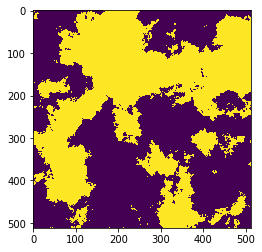

In [187]:
plt.imshow(all_FDs[2][12])

In [ ]:
##Transfert function##
from scipy import signal
num = [1, 2, 3]
den = [1, 2, 1]
signal.TransferFunction(num, den)

In [ ]:
##Evaluate relation between persistence and FD
FD_from_pers = []
for i in range(len(images[0])):
    FD_from_pers.append(fractal_dimension(images[3][i]))
FD_from_pers

In [95]:
size=512
images, list_p = generate_batch_monofractal(size=size, steps=20, min_p=0.25, max_p=0.95, n=50, save = False)

In [ ]:
print('Mean:', np.mean(FD_from_pers), 'Std:', np.std(FD_from_pers))


In [ ]:
import seaborn as sbn
sbn.distplot(FD_from_pers, bins = 50)

1.19
1.21
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(10, 512, 512)
1
1.24
1.26
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
(10, 512, 512)
2
1.29
1.31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
(10, 512, 512)
3
1.34
1.36
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
(10, 512, 512)
4
1.3900000000000001
1.4100000000000001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
(10, 512, 512)
5
1.4400000000000002
1.4600000000000002
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
(10, 512, 512)
6
1.4900000000000002
1.5100000000000002
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
(10, 512, 512)
7
1.5400000000000003
1.5600000000000003
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
(10, 512, 512)
8
1.5900000000000003
1.6100000000000003
1
2
3
4
5
6
7
8
9
10
1

In [191]:
#####FRACTAL CURVES#####
curve = 'decrease'
n_images = 15
min_fd = 1.2
max_fd = 1.9
dpi = 300
mono_fractal=False

In [217]:
list_FDs = np.arange(min_fd, max_fd, 0.05)
all_FDs = generate_controlled_FD_multi(images_new, list_FDs, n=n_images)

1.19
1.21
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(15, 512, 512)
1
1.24
1.26
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
(15, 512, 512)
2
1.29
1.31
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
(15, 512, 512)
3
1.34
1.36
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
(15, 512, 512)
4
1.3900000000000001
1.4100000000000001
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
(15, 512, 512)
5
1.4400000000000002
1.4600000000000002
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
(15, 512, 512)
6
1.4900000000000002
1.5100000000000002
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
(15, 512, 512)
7
1.5400000000000003
1.5600000000000003
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
(15, 512, 512)
8
1.5900000000000003
1.6100000000000003
1
2
3
4
5
6
7
8
9
10
1

In [195]:

list_FDs = np.arange(min_fd, max_fd, 0.05)
#all_FDs = generate_controlled_FD_multi(images, list_FDs, n=n_images) #Takes one image for each of the FD steps to generate the curve
#### Generates three options of fractal spectrums (linear, increasing, decreasing)
line = 100/len(list_FDs)
inc = (line/len(list_FDs))*0.5
low = line-((len(list_FDs)/2)*inc)
high= line+((len(list_FDs)/2)*inc)
if curve == 'flat':
    curve_shape = [line for i in range(len(list_FDs))]
if curve == 'increase':
    curve_shape = np.arange(low, high, (high-low)/len(list_FDs))
if curve == 'decrease':
    curve_temp = np.arange(low, high, (high-low)/len(list_FDs))
    curve_shape = curve_temp[::-1]

###Generate multiple fractal images###
from scipy import fftpack
if mono_fractal !=True:
    all_FDs = np.transpose(all_FDs, (1, 0, 2, 3))
for batch in range(len(all_FDs)):
    list_fft = []
    for e, fd in enumerate(all_FDs[batch]):
        print(fractal_dimension(all_FDs[batch][e]))
        list_fft.append(fftpack.fft2(all_FDs[batch][e]))
    list_fft = np.array(list_fft)
    for i in range(len(list_fft)-1):
        list_fft[i]=(list_fft[i]*curve_shape[i])
    final_fft = list_fft[0]
    for i in range(len(list_fft)-1):
        final_fft = (final_fft-list_fft[i+1])
    im_mf = fftpack.ifft2(final_fft).real
    im_mf = np.interp(im_mf, (im_mf.min(), im_mf.max()), (0, 255))
    im_mf = comp_contrast_mean(im_mf)
    im_mf = Image.fromarray(im_mf)
    im_mf = im_mf.convert("L")
    if not os.path.isdir('frac_curve_'+str(n_images)+'_'+str(min_fd)+'_'+str(max_fd)+'_'+curve):
        os.mkdir('frac_curve_'+str(n_images)+'_'+str(min_fd)+'_'+str(max_fd)+'_'+curve)
    im_mf.save("frac_curve_{}_{}_{}_{}/frac_curve_{}-{}-n{}.jpeg".format(n_images, min_fd, max_fd, curve, min_fd, max_fd, batch), dpi=(dpi, dpi))


1.1929507117035707
1.2091299191375293
1.2068904244748908
1.1926216908904321
1.1915091858575286
1.1960629870043928
1.2029514486392665
1.1940470432689552
1.2038587460739134
1.1915240118397739
1.1955456027738374
1.1966532777472756
1.2007846002829132
1.1929455167091172
1.2069439610376484
1.1929507117035707
1.2091299191375293
1.2068904244748908
1.1926216908904321
1.1915091858575286
1.2531881864402814
1.2029514486392665
1.252719837493436
1.2038587460739134
1.1915240118397739
1.2551924752268377
1.2593354728316937
1.2007846002829132
1.1929455167091172
1.2069439610376484
1.1929507117035707
1.3004562141516998
1.2068904244748908
1.1926216908904321
1.1915091858575286
1.2931521512517372
1.2029514486392665
1.3093963540662479
1.2038587460739134
1.1915240118397739
1.1955456027738374
1.1966532777472756
1.2007846002829132
1.2509547853069822
1.303834333484492
1.306979833290926
1.3452885237222698
1.2420505988458839
1.1926216908904321
1.2523178046229055
1.2531881864402814
1.2410131825486108
1.3559179268218

In [216]:
print(fractal_dimension(all_FDs[6][14]))

1.303834333484492


In [102]:
all_FDs = all_FDs.reshape(14,10,512,512)

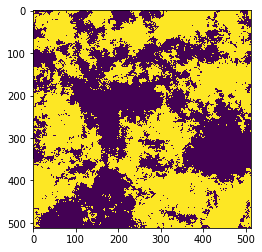

In [221]:
plt.imshow(all_FDs[12][1])

In [ ]:
#mu, sigma = 1.5, 0.3 # mean and standard deviation
#s = np.random.normal(mu, sigma, 10)


In [ ]:
im = fractal_generator(0.4, 512)
im2 = fractal_generator(0.5, 512)
im3 = fractal_generator(0.6, 512)
im4 = fractal_generator(0.9, 512)
im = comp_contrast(255*(im - np.min(im))/np.ptp(im)).astype('uint8')
im2 = comp_contrast(255*(im2 - np.min(im2))/np.ptp(im2)).astype('uint8')
im3 = comp_contrast(255*(im3 - np.min(im3))/np.ptp(im3)).astype('uint8')
im4 = comp_contrast(255*(im4 - np.min(im4))/np.ptp(im4)).astype('uint8')

In [ ]:
from scipy import fftpack
im_fft = fftpack.fft2(im)
im_fft2 = fftpack.fft2(im2)
im_fft3 = fftpack.fft2(im3)
im_fft4 = fftpack.fft2(im4)

In [ ]:

im_fft_new = (im_fft*10-im_fft2*10-im_fft3*10-im_fft4*10)
im_mf = fftpack.ifft2(im_fft_new).real

#im_mf = np.interp(im_mf, (im_mf.min(), im_mf.max()), (0, 255))
im_mf = comp_contrast_mean(im_mf)
im_mf = Image.fromarray(im_mf)
im_mf = im_mf.convert("L")
im_mf

In [ ]:
def fractal_spectrum(list_image, curve):
    mu, sigma = 0.6, 0.15 # mean and standard deviation of persistence of FD
    s = np.random.normal(mu, sigma, len(list_image))
    i = 0
    new_image = empty image
    while i < list_image: 
        
        new_image = (new_image+list_image[i])/2
        i =+1

In [ ]:
np.round(0.134, 2)

In [ ]:
list_op = ['fft_sub_contrast', 'fft_funk_contrast']
dpi = 200
for i in list_op:
    generate_batch_multifractal(512, 12, 0.4, 0.9, n_iter =15, op = i, contrast = 'pre', contrast_apply = True)

In [ ]:
test = comp_contrast(im)

In [ ]:
size = 256
im2x = fractal_generator(0.1, size)
imx = fractal_generator(0.2, size)
im4x = fractal_generator(0.7, size)
im3x = fractal_generator(0.9, size)
im2x = (255*(im2x - np.min(im2x))/np.ptp(im2x)).astype('uint8')
imx = (255*(imx - np.min(imx))/np.ptp(imx)).astype('uint8')
im4x = (255*(im4x - np.min(im4x))/np.ptp(im4x)).astype('uint8')
im3x = (255*(im3x - np.min(im3x))/np.ptp(im3x)).astype('uint8')

In [ ]:
size = 4096
im2x = fractal_generator(0.4, size)

In [ ]:
import seaborn as sbn
from scipy import fftpack
from matplotlib.colors import LogNorm
#plt.imshow(im2x)

im_fft = fftpack.fft2(contrast(im2x))
im_fft2 = fftpack.fft2(im4x)
#plt.imshow(im_fft.real, norm=LogNorm(vmin=5))
im_fft_new = (im_fft+im_fft2)/2
im_new = fftpack.ifft2(im_fft_new).real
plt.imshow(im_new,cmap='gray')

In [ ]:
im_test = (contrast(im4x)-contrast(im2x))
plt.imshow(im_test, cmap = 'gray')

In [ ]:
im_test
im_test.save("frac_test.jpeg", dpi = (dpi, dpi))

In [ ]:
from PIL import Image
dpi=300
im_test = Image.fromarray(im_test)
im_test.save("frac_test.jpeg", dpi=200)

In [ ]:
im = Image.open('test01.png')
im2 = Image.open('out01.png')
im3 = Image.open('out02.png')
im4 = Image.open('test04.png')
imx = np.array(im)
im2x = np.array(im2)
im3x = np.array(im3)
im4x = np.array(im4)

In [ ]:
list_dd = [imx, im2x, im3x, im4x]

In [ ]:



#imB = rgb2gray(imx)
#im2B = rgb2gray(im2x)
#sat = np.random.rand(1024, 1024)
#hue = np.full((1024, 1024), 0.05)
#imarray = np.array(image)
#imarray2 = np.array(image2)

h = im3x+im2x-imx
s = im3x-im2x
v = im3x-im2x+imx


im_RGB = np.stack((h, s, v), axis=2)
im_RGB2 = np.stack((im3x, im2x*2, imx), axis=2)
im_RGB3 = np.stack((im3x+(im4x*2-im2x), im2x*2, imx+im4x+im3x), axis=2)
im_RGB4 = np.stack((im3x-imx*im2x, im4x*2-imx*2, im4x-im3x-im2x*2), axis=2)
im_RGB5 = np.stack((im3x-imx+(im3x*4), im2x*2-imx-im2x, im2x.T+ im4x*2), axis=2)
im_RGB6 = np.stack((im3x-imx+im2x*2, im2x*2-imx-im4x, im4x-imx), axis=2)
#im_RGB.shape
img2 = Image.fromarray(im_RGB, mode='HSV')
img3 = Image.fromarray(im_RGB2, mode='HSV')
img4 = Image.fromarray(im_RGB3, mode='HSV')
img5 = Image.fromarray(im_RGB4, mode='HSV')
img6 = Image.fromarray(im_RGB5, mode='HSV')
img7 = Image.fromarray(im_RGB6, mode='HSV')
new_p = img2.convert('RGB')
new_p2 = img3.convert('RGB')
new_p3 = img4.convert('RGB')
new_p4 = img5.convert('RGB')
new_p5 = img6.convert('RGB')
new_p6 = img7.convert('RGB')

new_p = np.array(new_p)
new_p2 = np.array(new_p2)
new_p3 = np.array(new_p3)
new_p4 = np.array(new_p4)
new_p5 = np.array(new_p5)
new_p6 = np.array(new_p6)
list_image = [new_p, new_p2, new_p3, new_p4, new_p5, new_p6]

In [ ]:
#median filter

new_px = cv2.medianBlur(new_p,3)
plt.imshow(new_px)

In [ ]:
new_p.shape

In [ ]:
dpi=300
new_p.save("fract.jpeg", dpi=dpi)

In [ ]:
Interpol = InterpolMulti(1280, images, 30, direction = 0)
test_final = Interpol.astype('uint8')

In [ ]:
test_final.shape

In [ ]:
new_p = np.array(new_p)
new_p2 = np.array(new_p2)
test = Interpol(new_p, new_p2, 50, direction = 0)
test_final = np.array(test)
test_final = test_final.astype('uint8')

In [ ]:

#test_final = Image.fromarray(test_final[19], 'RGB')
#test_final

In [ ]:
plt.imshow(test_final[10])

In [ ]:
fig = plt.figure()
fig.set_size_inches(10, 10, True)
img = create_anim(test_final)

ani = animation.ArtistAnimation(fig, img, interval=120, blit=True,
                                    repeat_delay=None, repeat=False)

dpi = 128
writer = animation.writers['ffmpeg'](fps=20)
ani.save('test_dd_02.mp4',writer=writer,dpi=dpi)
#ani.save(("movie.mp4"), fps=18)#, writer='imagemagick', fps=20)
plt.show()

In [ ]:
choice = ['-', '+', '*']

In [ ]:
im_test.save("mani47.jpeg")

In [ ]:
im4 = np.array(im4)
fractal_dimension(im4)

In [ ]:
im2 = Image.open('D1.3_test.tif')
im3 = Image.open('D1.8_test.tif')
im4 = Image.open('D2.1_test.tif')

In [ ]:
# -----------------------------------------------------------------------------
# From https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension:
#
# In fractal geometry, the Minkowski–Bouligand dimension, also known as
# Minkowski dimension or box-counting dimension, is a way of determining the
# fractal dimension of a set S in a Euclidean space Rn, or more generally in a
# metric space (X, d).
# -----------------------------------------------------------------------------
import scipy.misc
import numpy as np


def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

#I = scipy.misc.imread("sierpinski.png")/256.0
#print("Minkowski–Bouligand dimension (computed): ", fractal_dimension(I))
#print("Haussdorf dimension (theoretical):        ", (np.log(3)/np.log(2)))